In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import soundfile as sf
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import (Dense, Flatten, Reshape, Concatenate, Conv2D,
                                     UpSampling2D, BatchNormalization, MaxPooling2D, Conv2DTranspose)
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

In [2]:
def get_prior(num_modes, latent_dim):
    gm = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(
            probs=[1.0/num_modes,]*num_modes),
        components_distribution = tfp.distributions.MultivariateNormalDiag(
          loc = tf.Variable(tf.random.normal(shape = [num_modes, latent_dim])),
          scale_diag = tfp.util.TransformedVariable(tf.Variable(tf.ones(shape = [num_modes, latent_dim])),
            bijector = tfp.bijectors.Softplus()))
    return gm


In [3]:
prior = get_prior(num_modes=2, latent_dim=100)

In [4]:
def get_kl_regularizer(prior_distribution):
    reg = tfp.layers.KLDivergenceRegularizer(
        prior_distribution,
        weight = 1.0,
        use_exact_kl = False,
        test_points_fn = lambda q : q.sample(3),
        test_points_reduce_axis = (0,1))
    return reg

In [5]:
kl_regularizer = get_kl_regularizer(prior)

In [6]:

def get_encoder(latent_dim, kl_regularizer):
    input_shape = (512,512,1)
    encoder = Sequential([
        Conv2D(filters = 32, kernel_size = 4, activation = 'relu',
               strides = 2, padding = 'SAME', input_shape = input_shape),
        BatchNormalization(),

        Conv2D(filters = 64, kernel_size = 4, activation = 'relu',
               strides = 2, padding = 'SAME'),
        BatchNormalization(),
        MaxPooling2D(pool_size=2, strides=2, padding='SAME'), 

        Conv2D(filters = 128, kernel_size = 4, activation = 'relu',
               strides = 2, padding = 'SAME'),
        BatchNormalization(),
        
        Conv2D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', padding = 'SAME'),
        BatchNormalization(),
        
        Conv2D(filters = 256, kernel_size = 4, strides = 2, activation = 'relu', padding = 'SAME'),
        BatchNormalization(),

        Flatten(),
        Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim)),

        tfp.layers.MultivariateNormalTriL(latent_dim, activity_regularizer = kl_regularizer)
    ])

    return encoder

In [7]:
encoder = get_encoder(latent_dim=100, kl_regularizer=kl_regularizer)

In [8]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      544       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                        

In [9]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(16384, activation = 'relu', input_shape = (latent_dim,)),
        Reshape((8, 8, 256)),
        UpSampling2D(size=(2, 2)),
        
        Conv2D(filters = 128, kernel_size = 3,
               activation = 'relu', padding = 'SAME'),
        BatchNormalization(),
        
        UpSampling2D(size=(2, 2)),
        Conv2D(filters = 64, kernel_size = 3,
               activation = 'relu', padding = 'SAME'),
        BatchNormalization(),
        
        UpSampling2D(size=(2, 2)),
        Conv2D(filters = 32 , kernel_size = 3,
               activation = 'relu', padding = 'SAME'),
        
        UpSampling2D(size=(2, 2)),
        Conv2D(filters = 128 , kernel_size = 3,
               activation = 'relu', padding = 'SAME'),
        
        UpSampling2D(size=(2, 2)),
        Conv2D(filters = 64 , kernel_size = 3,
               activation = 'relu', padding = 'SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(filters = 32 , kernel_size = 3,
            activation = 'relu', padding = 'SAME'),
        
        Conv2D(filters = 1 , kernel_size = 3, padding = 'SAME'),
        Flatten(),
        tfp.layers.IndependentBernoulli(event_shape = (512, 512, 1))
    ])

    return decoder

In [10]:
decoder = get_decoder(latent_dim=100)

In [11]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 16, 16, 256)       0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_5 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 32, 32, 128)      

In [12]:

def reconstruction_loss(batch_of_images, decoding_dist):
    return -tf.reduce_sum(decoding_dist.log_prob(batch_of_images), axis = 0)

In [13]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [14]:
data = np.load('data.npz')
loaded_spectrograms = np.array([data[f'{i}'] for i in range(len(data))])

In [15]:
train_data = loaded_spectrograms[:1100]
val_data = loaded_spectrograms[1100:]
print(len(train_data))

1100


In [16]:
import numpy as np
train_dtype = train_data.dtype
val_dtype = val_data.dtype

print("Train data dtype:", train_dtype)
print("Val data dtype:", val_dtype)

def contains_complex(data):
    return np.iscomplex(data).any()

print("Train data contains complex:", contains_complex(train_data))
print("Val data contains complex:", contains_complex(val_data))


Train data dtype: float32
Val data dtype: float32
Train data contains complex: False
Val data contains complex: False


In [41]:
from tensorflow.keras.models import load_model

custom_objects = {
    'tfp.layers.IndependentBernoulli': tfp.layers.IndependentBernoulli,
    'tfp.layers.MultivariateNormalTriL': tfp.layers.MultivariateNormalTriL
}

vae.load_weights('best_model_2.keras')

In [ ]:
checkpoint_cb = ModelCheckpoint(
    'best_model_2.keras', 
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

def data_generator(data, batch_size):
    while True:
        for i in range(0, len(data), batch_size):
            x_batch = data[i:i+batch_size]
            yield x_batch, x_batch  

train_gen = data_generator(train_data, batch_size=16)
val_gen = data_generator(val_data, batch_size=16)

train_steps = len(train_data) // 16
val_steps = len(val_data) // 16

history = vae.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=200,
    callbacks=[checkpoint_cb]
)

Epoch 1/200
68/68 [==============================] - 467s 7s/step - loss: 98862.7422 - val_loss: 162946.4531
Epoch 2/200
68/68 [==============================] - 464s 7s/step - loss: 98653.2109 - val_loss: 131462.8594
Epoch 3/200
68/68 [==============================] - 464s 7s/step - loss: 98018.7812 - val_loss: 128065.7969
Epoch 4/200
61/68 [=========================>....] - ETA: 43s - loss: 98711.9141

In [48]:
def generate_music(prior, decoder, n_samples):
    z = prior.sample(n_samples)
    return decoder(z).mean()

n_samples = 5
sm = generate_music(prior, decoder, n_samples)
print(sm[0])

tf.Tensor(
[[[0.07024781]
  [0.06584191]
  [0.04403076]
  ...
  [0.02211033]
  [0.03608297]
  [0.07937202]]

 [[0.06505255]
  [0.07562295]
  [0.06580748]
  ...
  [0.02760453]
  [0.03069986]
  [0.04465031]]

 [[0.04198   ]
  [0.04304703]
  [0.0444486 ]
  ...
  [0.0238369 ]
  [0.02841101]
  [0.03797952]]

 ...

 [[0.00451697]
  [0.00091809]
  [0.00060026]
  ...
  [0.00021816]
  [0.00048444]
  [0.00174894]]

 [[0.00848254]
  [0.00218055]
  [0.00130982]
  ...
  [0.00048421]
  [0.00118377]
  [0.00411502]]

 [[0.03270094]
  [0.01049867]
  [0.00567644]
  ...
  [0.00206636]
  [0.00670037]
  [0.01510378]]], shape=(512, 512, 1), dtype=float32)


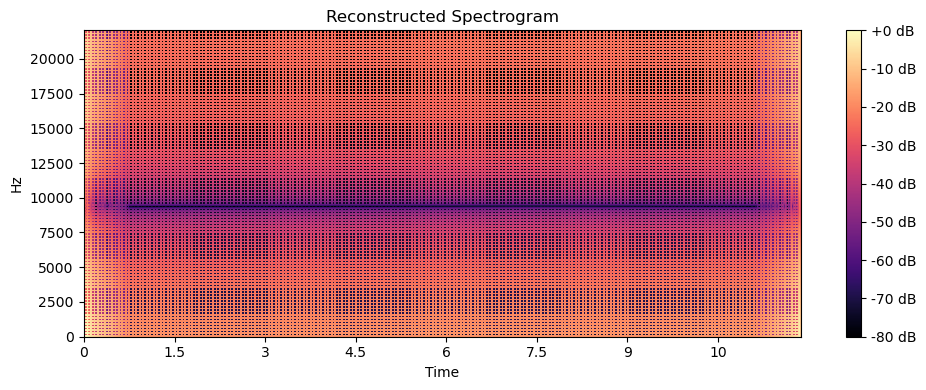

In [49]:
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

FIXED_MIN_VAL = 0  
FIXED_MAX_VAL = 247

def inverse_normalize_spectrogram(normalized_spectrogram):
    return normalized_spectrogram * (FIXED_MAX_VAL - FIXED_MIN_VAL) + FIXED_MIN_VAL

def stft_to_audio(tensor, output_path, sr=44100, hop_length=512):
    tensor_np = tensor.numpy() if isinstance(tensor, tf.Tensor) else tensor
    tensor_np = inverse_normalize_spectrogram(tensor_np[:, :, 0])
    y_reconstructed = librosa.istft(tensor_np, n_fft=1024, hop_length=1024)
    sf.write(output_path, y_reconstructed, sr)
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_reconstructed)), ref=np.max)
    librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Reconstructed Spectrogram')
    plt.tight_layout()
    plt.show()
    
stft_to_audio(sm[4], 'new4.wav')
